# XGBoost with Grid Search Setup
- Grid Search is used to find the best parameters for the model
- It is a brute force method that tries all the combinations of parameters to find the best combination [cv = n means (n-fold cross validation)]

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
#Grid Search
from sklearn.model_selection import GridSearchCV

# Load the cleaned dataset
df = pd.read_csv('../../../../Data/Creation/CSV/Combined_Log_Transformed_Excl_Roil.csv')


df.head()

,date,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,Real Oil Prices
0,1986-01,8.817058,8.688117,3.857715,13.408814,11.719838,4.019102,4.149063,4.123819,4.290384,...,3.818964,2.315501,2.465554,2.254445,4.560173,11.178487,11.711347,6.117475,2.897088,20.864422
1,1986-02,8.821909,8.693279,3.855241,13.403109,11.710476,4.012230,4.139512,4.113869,4.281726,...,3.823585,2.316488,2.468100,2.257588,4.563306,11.191452,11.721119,6.117194,3.026465,14.092981
2,1986-03,8.831298,8.702643,3.858643,13.404085,11.703515,4.005200,4.136150,4.110498,4.278101,...,3.827946,2.317474,2.462150,2.259678,4.554929,11.207555,11.730876,6.109472,3.159720,11.558203
3,1986-04,8.834686,8.705961,3.864785,13.424021,11.709872,4.006344,4.139662,4.111926,4.284721,...,3.829749,2.318459,2.468947,2.257588,4.566429,11.231676,11.744940,6.120473,3.136164,11.812328
4,1986-05,8.835888,8.706755,3.870784,13.414384,11.724289,4.008305,4.143116,4.114232,4.290291,...,3.831030,2.320425,2.473171,2.260721,4.551769,11.269783,11.768419,6.127810,2.938781,14.110092


### Convert date to year, day so that it can be used in the model.
- Regression models (like random forest) can't use date as a feature. So we convert it to year and day.

In [2]:
# Convert 'date' column to datetime objects
df['date'] = pd.to_datetime(df['date'], format='%Y-%m')

# Extract the year and month from the datetime object
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month


# Remove the date column
df.drop('date', axis=1, inplace=True)

df.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,Real Oil Prices,year,month
0,8.817058,8.688117,3.857715,13.408814,11.719838,4.019102,4.149063,4.123819,4.290384,3.957004,...,2.465554,2.254445,4.560173,11.178487,11.711347,6.117475,2.897088,20.864422,1986,1
1,8.821909,8.693279,3.855241,13.403109,11.710476,4.012230,4.139512,4.113869,4.281726,3.950203,...,2.468100,2.257588,4.563306,11.191452,11.721119,6.117194,3.026465,14.092981,1986,2
2,8.831298,8.702643,3.858643,13.404085,11.703515,4.005200,4.136150,4.110498,4.278101,3.949552,...,2.462150,2.259678,4.554929,11.207555,11.730876,6.109472,3.159720,11.558203,1986,3
3,8.834686,8.705961,3.864785,13.424021,11.709872,4.006344,4.139662,4.111926,4.284721,3.948494,...,2.468947,2.257588,4.566429,11.231676,11.744940,6.120473,3.136164,11.812328,1986,4
4,8.835888,8.706755,3.870784,13.414384,11.724289,4.008305,4.143116,4.114232,4.290291,3.950313,...,2.473171,2.260721,4.551769,11.269783,11.768419,6.127810,2.938781,14.110092,1986,5


## Splitting the data into train and test sets

In [3]:
# Splitting the data into features and target
X = df.drop('Real Oil Prices', axis=1)
y = df['Real Oil Prices']

# Split the data into training and testing sets (80% for training and 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Grid Search to find the best parameters

In [4]:
# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [10, 50, 100, 300],
    'learning_rate': [0.001, 0.01, 0.1, 0.3],
    'max_depth': [1, 2, 3, 5],
}

# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', seed=42)

# Set up the grid search
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Use the best model to make predictions
best_xgb_model = grid_search.best_estimator_
predictions = best_xgb_model.predict(X_test)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


Best parameters found:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}


## Evaluating the model with best parameters

In [5]:
# Evaluate the model
xgb_mae = mean_absolute_error(y_test, predictions)
xgb_mse = mean_squared_error(y_test, predictions)
xgb_r2 = r2_score(y_test, predictions)
xgb_mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
xgb_rmse = np.sqrt(xgb_mse)

print(f"XGBoost Mean Absolute Error: {xgb_mae}")
print(f"XGBoost Mean Squared Error: {xgb_mse}")
print(f"XGBoost Root Mean Squared Error: {xgb_rmse}")
print(f"XGBoost R2 Score: {xgb_r2}")
print(f"XGBoost MAPE: {xgb_mape}")

XGBoost Mean Absolute Error: 1.4828102534350984
XGBoost Mean Squared Error: 4.1207168887029635
XGBoost Root Mean Squared Error: 2.0299548981942834
XGBoost R2 Score: 0.9560799354799919
XGBoost MAPE: 7.102512233364175


## Feature Importance

<Figure size 1000x1200 with 0 Axes>

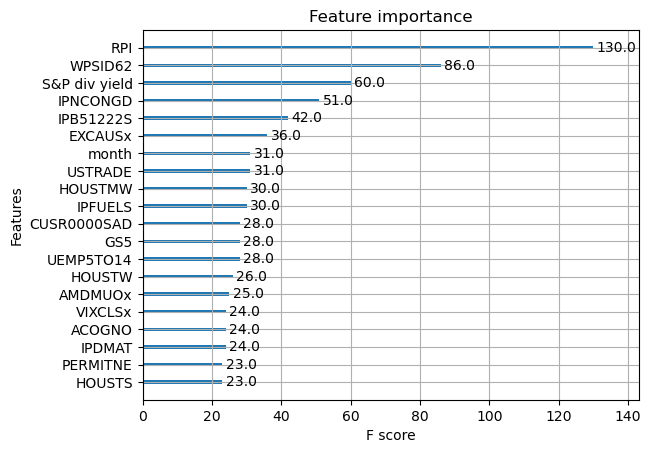

In [6]:
# Plotting feature importances for the best model
plt.figure(figsize=(10, 12))
plot_importance(best_xgb_model, max_num_features=20)
plt.show()

## Actual vs Predicted

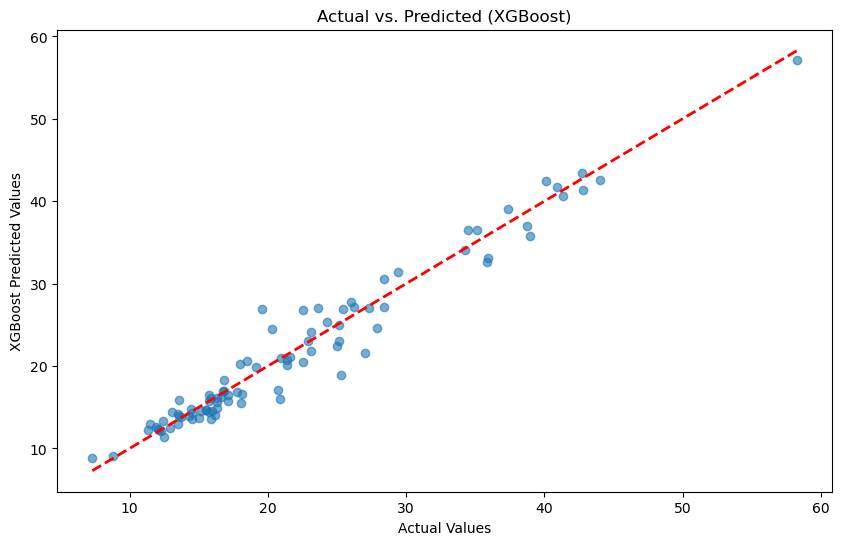

In [7]:
# Actual vs. Predicted scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('XGBoost Predicted Values')
plt.title('Actual vs. Predicted (XGBoost)')
plt.show()

### Learning Curve

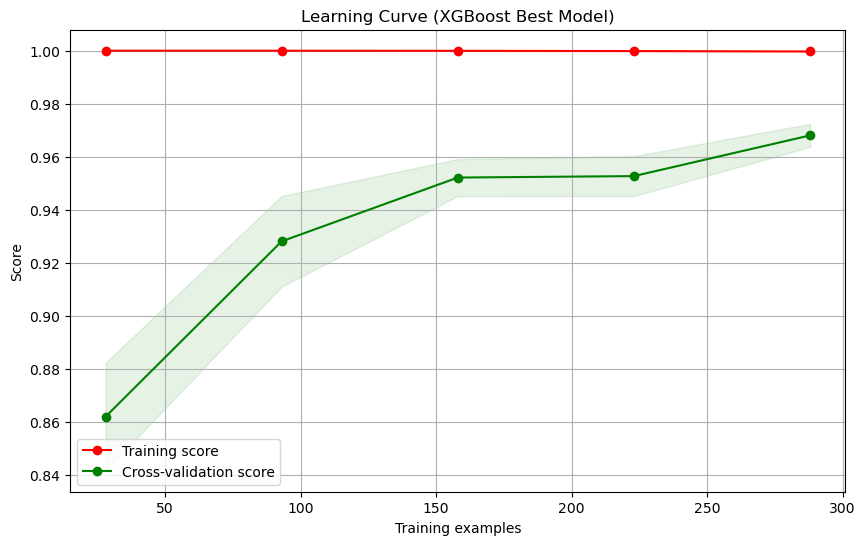

In [8]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    # Fill between lines to indicate standard deviation
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # Plot the average training and test scores
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot the learning curve for the XGBoost model
plot_learning_curve(best_xgb_model, "Learning Curve (XGBoost Best Model)", X_train, y_train, cv=5)
plt.show()

- The Training score curve (in red) shows how the model's performance on the training data changes as more data is used.
- The Cross-validation score curve (in green) shows how the model's performance on a validation set changes as more training data is used.